<a href="https://colab.research.google.com/github/dnrghks5583/Way-that-set-threshold-for-setting-PMD/blob/main/CALTECH-101/Cross_Entropy_ResNet_CALTECH_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from keras.models import load_model
import tensorflow as tf
import os

drive.mount('/content/gdrive')

#load most recent saved model
directory_name = 'CALTECH-101_saved_models_with_batch32_lr_e-3'
learning_rate_variable = int(directory_name[-1])
path = '/content/gdrive/MyDrive/Colab Notebooks/ResNet_졸과/GP/pickle_101_164'

os.chdir(path)


directory_path = path+'/' + directory_name + '/'
file_name_and_time_lst = []

for saved_models in os.listdir(f"{directory_path}"):
    written_time = os.path.getctime(f"{directory_path}{saved_models}")
    file_name_and_time_lst.append((saved_models, written_time))
 
sorted_file_lst = sorted(file_name_and_time_lst, key=lambda x: x[1], reverse=True)
latest_model = sorted_file_lst[0][0] #originally [0][0]
print('\nLoaded model name : ' , latest_model)

#pickup from the last epoch
initial_epoch = int(latest_model[len(latest_model)-6:-3])

model = tf.keras.models.load_model(directory_path + latest_model)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Loaded model name :  CALTECH-101_ResNet56v1_model.120.h5


In [3]:
import gzip
import pickle

with gzip.open('caltech101_x_trainData.pickle', 'rb') as f:
    x_train = pickle.load(f)
    
with gzip.open('caltech101_x_testData.pickle', 'rb') as f:
    x_test = pickle.load(f)
    
with gzip.open('caltech101_y_testData.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [4]:
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math
import cv2

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# input image dimensions.
input_shape = x_train.shape[1:]
img_size = tuple(x_train.shape[1:3])

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (7316, 164, 164, 3)
7316 train samples
1829 test samples


In [5]:
y_pred = model.predict(x_test)
model.evaluate(x_test, y_test)

58/58 [==============================] - 5s 70ms/step - loss: 1.7210 - acc: 0.7753


[1.720956563949585, 0.7752870321273804]

In [6]:
import tensorflow

cce = tensorflow.keras.losses.categorical_crossentropy(
    y_test,
    y_pred,
    from_logits = False,
    label_smoothing = 0)
cce = cce.numpy()
print(cce)

[1.1920930e-07 1.6201142e-03 1.6118095e+01 ... 9.9594884e-02 8.4219255e+00
 1.1920930e-07]


In [7]:
def classification_Cce(cce, y_test, y_pred) :
  c = []
  m = []
  c_i = []

  for i in range(len(y_test)) :
    if np.argmax(y_test[i]) == np.argmax(y_pred[i]) :
      c.append(cce[i])
      c_i.append(i)
    else :
      m.append(cce[i])

  return c, m, c_i

def static_Threshold() :
  threshold = []
  for i in range(1, 10):
    threshold.append(round(i * 0.1, 1))
  return threshold  


def dynamic_Threshold(missclassification_Cce, cce) :
  #Z = [1.96, 2.17, 2.576] # 95%, 97%, 99% two-tails
  Z = [1.645, 1.96, 2.326] # 95%, 97.5%, 99% one-tails
  threshold = [min(missclassification_Cce)]
  x_ = np.mean(cce)
  o = np.std(missclassification_Cce)
  n_ = (len(missclassification_Cce))**0.5

  for z in Z :
    threshold.append(x_- (z * o)/n_)
  
  return threshold    

def detection(threshold, cce, collect) : 
  PMD = []
  for i in collect :
    if cce[i] > threshold :
        PMD.append(i)
  return PMD

def detection_PMD(list_of_threshold, cce, collect):
  PMD_by_threshold = []

  for th in list_of_threshold :
    PMD_by_threshold.append(detection(th, cce, collect))
  return PMD_by_threshold


def rotate_img_set(data_set, angle) : # 10' ~ 90'
  rotated_img = []
  print("rotate " + str(angle) + "degree")
  for img in data_set :
    m = cv2.getRotationMatrix2D((64, 64), angle, 1)
    new_img = cv2.warpAffine(img, m, img_size, cv2.INTER_AREA, borderMode = 1)
    rotated_img.append(new_img)
    
  return rotated_img

def img_trim(img, size) :
  w = img_size[0]
  h = img_size[1]
  new_img = img[size:size+h, size:size+w]
  return new_img


def size_Adjust(x_test, rate) :

  new_data_set = []
  if rate > 1 : # aggmentation
    print("augmentation " + str(rate) + "%")
    size = round(128*rate/2 - 64)
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_LINEAR)
      new_img = img_trim(new_img, size)
      new_data_set.append(new_img)
  else :  # reduction
    print("reduction " + str(rate) + "%")
    size = round(64 * (1-rate))
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_AREA)
      new_img = np.pad(new_img, ((size, size), (size, size), (0, 0)), mode = 'edge')
      new_img = cv2.resize(new_img, img_size, interpolation = cv2.INTER_AREA)
      new_data_set.append(new_img)

  return new_data_set

def get_MD(y_pred, new_y_pred, y_test) :
  MD = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) and np.argmax(new_y_pred[i]) != np.argmax(y_test[i]) :
      MD.append(i)
  print("    Find MD : " + str(len(MD)))
  return MD

def calc_Acc(new_y_pred, y_test) :
  cnt = 0
  for i in range(len(y_pred)) :
    if np.argmax(new_y_pred[i]) == np.argmax(y_test[i]) :
      cnt = cnt + 1
  acc = cnt/len(y_pred)
  print("  Acc : " + str(acc))

def get_PMD_Precision(MD, PMD) :
  cnt = 0
  if len(PMD) == 0 :
    return 0
  for data in PMD : 
    if data in MD :
      cnt = cnt + 1
  precision = cnt/len(PMD)
  print("        Precision : " + str(precision))
  return precision

def get_PMD_Recall(MD, PMD) :
  cnt = 0
  if len(MD) == 0 :
    return 0
  for data in MD : 
    if data in PMD :
      cnt = cnt + 1
  recall = cnt/len(MD)
  print("        Recall : " + str(recall))
  return recall    

def get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test) : #
  Stp = []   # [ th = 0.1_pre1, th = 0.2_pre2, ... , th = 0.9_pre9 ] number of elements = 9
  Dtp = []   # [ th = min_pre1, th = 95%_pre2, ... , th = 99%_pre4 ] number of elements = 4
  Str = []   # [ th = 0.1_rec1, th = 0.2_rec2, ... , th = 0.9_rec9 ] number of elements = 9
  Dtr = []   # [ th = min_rec1, th = 95%_rec2, ... , th = 99%_rec4 ] number of elements = 4
  st = 1
  dt = 1

  new_y_pred = model.predict(data_set)
  calc_Acc(new_y_pred, y_test)
  MD = get_MD(y_pred, new_y_pred, y_test)

  print("      " + "static threshold")
  for s in PMD_By_Static_Threshold :
    print("        " + str(st) + "st static threshold")
    st = st + 1
    Stp.append(get_PMD_Precision(MD, s))
    Str.append(get_PMD_Recall(MD, s))
    print()

  print("      " + "dynamic threshold")
  for d in PMD_By_Dynamic_Threshold :
    print("        " + str(dt) + "st dynamic threshold")
    dt = dt + 1
    Dtp.append(get_PMD_Precision(MD, d))
    Dtr.append(get_PMD_Recall(MD, d))
    print()

  return Stp, Dtp, Str, Dtr

def get_Avg_Result(lists) : #
  x = len(lists[0]) # static = 9, dynamic = 4
  y = len(lists)    # aggmentation, reduction = 4, rotate = 9
  Avg = []

  for i in range(x) :
    temp = 0
    for j in range(y) :
      temp = temp + lists[j][i]
    Avg.append(temp/y)
  return Avg

def validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rate, rotated = False) : #

  stp_Result = []
  dtp_Result = []
  str_Result = []
  dtr_Result = []

  for rate in list_of_rate :
    if rotated :
      data_set = rotate_img_set(x_test, rate)
    else :
      data_set = size_Adjust(x_test, rate)
    data_set = np.array(data_set)
    
    Stp, Dtp, Str, Dtr = get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test)
    stp_Result.append(Stp)
    dtp_Result.append(Dtp)
    str_Result.append(Str)
    dtr_Result.append(Dtr)

  stp_Result = get_Avg_Result(stp_Result)
  dtp_Result = get_Avg_Result(dtp_Result)
  str_Result = get_Avg_Result(str_Result)
  dtr_Result = get_Avg_Result(dtr_Result)
  return stp_Result, dtp_Result, str_Result, dtr_Result

def print_Result(stp_Result, dtp_Result, str_Result, dtr_Result, comments, staticThreshold, dynamicThreshold) :
  print(comments)
  print(staticThreshold)
  print(stp_Result)
  print(str_Result)
  print(dynamicThreshold)
  print(dtp_Result)
  print(dtr_Result)        

In [8]:
collect_Cce, missclassification_Cce, collect_Idx = classification_Cce(cce, y_test, y_pred)
print(len(collect_Cce))
print(len(missclassification_Cce))

1418
411


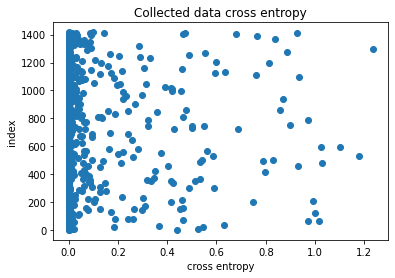

In [9]:
x_value = []
for i in range(len(collect_Cce)) :
  x_value.append(i)

plt.scatter(collect_Cce, x_value)
plt.title('Collected data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

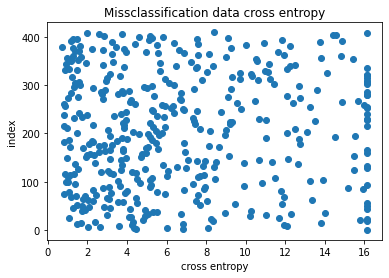

In [10]:
X_value = []
for i in range(len(missclassification_Cce)) :
  X_value.append(i)

plt.scatter(missclassification_Cce, X_value)
plt.title('Missclassification data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

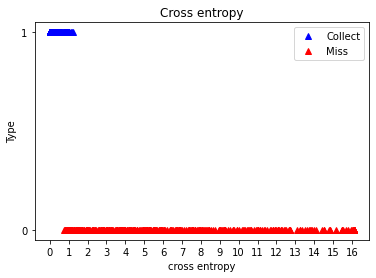

In [11]:
Y = []
for i in range(len(collect_Cce)) :
  Y.append(1)
y = []
for i in range(len(missclassification_Cce)) :
  y.append(0)

values = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12 ,13, 14, 15, 16]

plt.plot(collect_Cce, Y, 'b^', missclassification_Cce, y, 'r^')
plt.title('Cross entropy')
plt.ylabel('Type')
plt.xlabel('cross entropy')
plt.legend(['Collect', 'Miss'])
plt.yticks([1,0])
plt.xticks(values)

plt.show()

In [12]:
print(max(collect_Cce))
print(min(missclassification_Cce))

1.235457
0.7308233


In [13]:
section = []
section_rate = []
max_m = round(max(missclassification_Cce))

for i in range(max_m+1) :
  section.append(0)

for m in missclassification_Cce :
  section[round(m)] = section[round(m)] + 1

  
for i in range(max_m+1):
    section_rate.append(section[i]/len(missclassification_Cce))

print(section)
print(section_rate)

[0, 46, 38, 38, 47, 37, 27, 23, 30, 17, 12, 17, 19, 9, 9, 9, 33]
[0.0, 0.11192214111922141, 0.09245742092457421, 0.09245742092457421, 0.11435523114355231, 0.09002433090024331, 0.06569343065693431, 0.05596107055961071, 0.072992700729927, 0.0413625304136253, 0.029197080291970802, 0.0413625304136253, 0.046228710462287104, 0.021897810218978103, 0.021897810218978103, 0.021897810218978103, 0.08029197080291971]


In [14]:
staticThreshold = static_Threshold()
print(staticThreshold)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [15]:
dynamicThreshold = dynamic_Threshold(missclassification_Cce, cce)
print(dynamicThreshold)

[0.7308233, 1.173613789207401, 1.1018483770124685, 1.018463802843118]


In [16]:
PMD_By_Static_Threshold  = detection_PMD(staticThreshold, cce, collect_Idx)
PMD_By_Dynamic_Threshold = detection_PMD(dynamicThreshold, cce, collect_Idx)

print("PMD by static threshold length : " , len(PMD_By_Static_Threshold))
print("\nPMD by static threshold : " , PMD_By_Static_Threshold)
print("\nPMD by dynamic threshold length" , len(PMD_By_Dynamic_Threshold))
print("\nPMD by dynamic threshold : " , PMD_By_Dynamic_Threshold)

PMD by static threshold length :  9

PMD by static threshold :  [[4, 12, 28, 29, 37, 51, 81, 87, 96, 97, 98, 103, 156, 160, 188, 194, 198, 201, 212, 233, 272, 275, 277, 280, 291, 305, 308, 315, 363, 378, 404, 409, 414, 453, 457, 471, 473, 475, 485, 491, 498, 561, 564, 605, 611, 612, 645, 649, 656, 662, 663, 665, 672, 701, 705, 706, 724, 728, 738, 753, 768, 776, 785, 792, 854, 907, 915, 946, 947, 958, 973, 974, 977, 986, 1025, 1027, 1043, 1054, 1055, 1058, 1096, 1108, 1115, 1119, 1126, 1130, 1185, 1229, 1231, 1258, 1268, 1299, 1305, 1306, 1321, 1335, 1343, 1360, 1368, 1370, 1380, 1429, 1434, 1448, 1463, 1473, 1474, 1481, 1484, 1502, 1512, 1530, 1560, 1563, 1569, 1584, 1602, 1611, 1622, 1628, 1640, 1654, 1660, 1684, 1715, 1773, 1800, 1814, 1815, 1818, 1820, 1825], [4, 12, 29, 37, 51, 81, 87, 96, 98, 103, 156, 188, 194, 198, 212, 233, 275, 277, 280, 291, 308, 315, 404, 409, 453, 471, 473, 475, 485, 491, 498, 561, 564, 611, 612, 645, 649, 656, 663, 665, 672, 701, 705, 706, 728, 738, 753, 7

In [17]:
list_of_ag_rate = np.arange(1.1, 1.5, 0.1)
list_of_rd_rate = np.arange(0.9, 0.5, -0.1)
list_of_degree = np.arange(10, 100, 10)

In [18]:
rot_Stp, rot_Dtp, rot_Str, rot_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_degree, True)   ## rotated

rotate 10degree
  Acc : 0.7413887370147622
    Find MD : 105
      static threshold
        1st static threshold
        Precision : 0.4621212121212121
        Recall : 0.580952380952381

        2st static threshold
        Precision : 0.5
        Recall : 0.4857142857142857

        3st static threshold
        Precision : 0.5443037974683544
        Recall : 0.4095238095238095

        4st static threshold
        Precision : 0.5846153846153846
        Recall : 0.3619047619047619

        5st static threshold
        Precision : 0.5909090909090909
        Recall : 0.24761904761904763

        6st static threshold
        Precision : 0.6551724137931034
        Recall : 0.18095238095238095

        7st static threshold
        Precision : 0.72
        Recall : 0.17142857142857143

        8st static threshold
        Precision : 0.75
        Recall : 0.14285714285714285

        9st static threshold
        Precision : 0.8461538461538461
        Recall : 0.10476190476190476

      dyna

In [19]:
ag_Stp, ag_Dtp, ag_Str, ag_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_ag_rate, False)    ## augmentation

augmentation 1.1%
  Acc : 0.7512301804264625
    Find MD : 91
      static threshold
        1st static threshold
        Precision : 0.36363636363636365
        Recall : 0.5274725274725275

        2st static threshold
        Precision : 0.45098039215686275
        Recall : 0.5054945054945055

        3st static threshold
        Precision : 0.4810126582278481
        Recall : 0.4175824175824176

        4st static threshold
        Precision : 0.5230769230769231
        Recall : 0.37362637362637363

        5st static threshold
        Precision : 0.5227272727272727
        Recall : 0.25274725274725274

        6st static threshold
        Precision : 0.6896551724137931
        Recall : 0.21978021978021978

        7st static threshold
        Precision : 0.68
        Recall : 0.18681318681318682

        8st static threshold
        Precision : 0.65
        Recall : 0.14285714285714285

        9st static threshold
        Precision : 0.6923076923076923
        Recall : 0.098901098

In [20]:
rd_Stp, rd_Dtp, rd_Str, rd_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rd_rate, False)   ## reduction

reduction 0.9%
  Acc : 0.7577911427009295
    Find MD : 72
      static threshold
        1st static threshold
        Precision : 0.4090909090909091
        Recall : 0.75

        2st static threshold
        Precision : 0.43137254901960786
        Recall : 0.6111111111111112

        3st static threshold
        Precision : 0.4810126582278481
        Recall : 0.5277777777777778

        4st static threshold
        Precision : 0.47692307692307695
        Recall : 0.4305555555555556

        5st static threshold
        Precision : 0.5454545454545454
        Recall : 0.3333333333333333

        6st static threshold
        Precision : 0.5517241379310345
        Recall : 0.2222222222222222

        7st static threshold
        Precision : 0.6
        Recall : 0.20833333333333334

        8st static threshold
        Precision : 0.55
        Recall : 0.1527777777777778

        9st static threshold
        Precision : 0.6153846153846154
        Recall : 0.1111111111111111

      dynamic

In [21]:
print_Result(rot_Stp, rot_Dtp, rot_Str, rot_Dtr, "Rotation", staticThreshold, dynamicThreshold)

Rotation
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.818181818181818, 0.8311546840958606, 0.8382559774964838, 0.8461538461538463, 0.8333333333333334, 0.842911877394636, 0.8488888888888888, 0.8333333333333335, 0.8632478632478633]
[0.15964444775500858, 0.12822685804693806, 0.10305400783861679, 0.08785947904334249, 0.05913160952991339, 0.04140154649078316, 0.0373910952155678, 0.03022869551879405, 0.02124451790804143]
[0.7308233, 1.173613789207401, 1.1018483770124685, 1.018463802843118]
[0.8488888888888888, 1.0, 1.0, 0.8222222222222222]
[0.0373910952155678, 0.003834293472134813, 0.003834293472134813, 0.006642558343168801]


In [22]:
print_Result(ag_Stp, ag_Dtp, ag_Str, ag_Dtr, "Augmentation", staticThreshold, dynamicThreshold)

Augmentation
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.509469696969697, 0.5686274509803921, 0.5949367088607596, 0.6230769230769231, 0.6306818181818181, 0.7241379310344828, 0.7, 0.7, 0.6923076923076923]
[0.35218908050009406, 0.31384132332535614, 0.2558147287006963, 0.22137432673442886, 0.150811845682406, 0.11921724964229555, 0.10009444434691891, 0.07830910589901946, 0.05117488031112791]
[0.7308233, 1.173613789207401, 1.1018483770124685, 1.018463802843118]
[0.7, 0.5, 0.5, 0.75]
[0.10009444434691891, 0.0058440205347537275, 0.0058440205347537275, 0.02187005804262937]


In [23]:
print_Result(rd_Stp, rd_Dtp, rd_Str, rd_Dtr, "Reduction", staticThreshold, dynamicThreshold)

Reduction
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.5473484848484849, 0.5637254901960784, 0.5727848101265823, 0.5769230769230769, 0.6136363636363636, 0.5775862068965518, 0.6200000000000001, 0.6375, 0.6538461538461539]
[0.4697652002565992, 0.3805361367587078, 0.31150441875167184, 0.2568308971881144, 0.18939379471901813, 0.12028406270525947, 0.11219891795479615, 0.089704531403966, 0.061517971524938875]
[0.7308233, 1.173613789207401, 1.1018483770124685, 1.018463802843118]
[0.6200000000000001, 1.0, 1.0, 0.7]
[0.11219891795479615, 0.014929594711844766, 0.014929594711844766, 0.024193984745326958]
